<a href="https://colab.research.google.com/github/braxtonowens/OneraDataset/blob/master/Onera_Multispec_FC_EF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/braxtonowens/OneraDataset.git

Cloning into 'OneraDataset'...
remote: Enumerating objects: 1945, done.
remote: Total 1945 (delta 0), reused 0 (delta 0), pack-reused 1945
Receiving objects: 100% (1945/1945), 905.99 MiB | 30.63 MiB/s, done.
Resolving deltas: 100% (201/201), done.
Checking out files: 100% (1857/1857), done.


Here we take the original images and create lots of random smaller images returning arrays of the images and masks.

In [ ]:
from osgeo import gdal
import numpy as np
import os
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt


# Choose from bands (B01, B02, B02, B04, B05, B06, B07, B08, B09, B10, B11, B12, B8A)
channels = ['B02','B03','B04','B08']
# path to Onera Dataset
mainDir = 'OneraDataset/OneraData'
images = '/images'
labels = '/labels'
IMAGE_SIZE = 96


def create_stacked_chips(channels, mainDir, images, labels, IMAGE_SIZE):
  #countImage = []
  mainPath = mainDir
  imgPath = mainDir + images
  lblPath = mainDir + labels
  img_list = np.zeros((908,96,96,8))
  lbl_list = np.zeros((908,96,96,1))
  city_ls = os.listdir(lblPath)
  city_ls.remove('README.txt')
  if not('mini_images' in os.listdir(mainPath)):
    os.mkdir(mainPath +'/mini_images')
    os.mkdir(mainPath +'/mini_labels')
  k = 0
  for city in city_ls:
    beforeList = []
    afterList = []
    lblList = []
    for channel in channels:
      img_file1 = imgPath + '/'+ city + '/imgs_1_rect/' + channel + '.tif'
      ds = gdal.Open(img_file1, gdal.GA_ReadOnly)
      rb = ds.GetRasterBand(1)
      beforeList.append(rb.ReadAsArray())
      img_file2 = imgPath + '/' + city + '/imgs_2_rect/' + channel + '.tif'
      ds = gdal.Open(img_file2, gdal.GA_ReadOnly)
      rb = ds.GetRasterBand(1)
      afterList.append(rb.ReadAsArray())
      lbl_file = lblPath + '/' + city + '/cm/' + city + '-cm' '.tif'
      ds = gdal.Open(lbl_file, gdal.GA_ReadOnly)
      rb = ds.GetRasterBand(1)
      lblList.append(rb.ReadAsArray())
    y = 0
    
    for i in range(beforeList[0].shape[1]//IMAGE_SIZE):
        x = 0
        for j in range(beforeList[0].shape[0]//IMAGE_SIZE):
            before_mini_img1 = beforeList[0][x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]
            before_mini_img2 = beforeList[1][x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]
            before_mini_img3 = beforeList[2][x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]
            before_mini_img4 = beforeList[3][x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]

            after_mini_img1 = afterList[0][x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]
            after_mini_img2 = afterList[1][x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]
            after_mini_img3 = afterList[2][x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]
            after_mini_img4 = afterList[3][x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]


            lbl_mini_img1 = lblList[0][x:x+IMAGE_SIZE,y:y+IMAGE_SIZE] - 1
 
            img_list[k] = tf.stack([before_mini_img1,before_mini_img2,before_mini_img3,before_mini_img4,after_mini_img1,after_mini_img2,after_mini_img3,after_mini_img4],axis=2)

            mini_lbl = np.expand_dims(lbl_mini_img1,2)
            lbl_list[k] = (mini_lbl)
            x += IMAGE_SIZE
            k +=1
        y += IMAGE_SIZE
  print(img_list.shape)
  print(lbl_list.shape)
  return img_list/4095, lbl_list 

Uses sklearn library to split our data into training and testing batches.

In [ ]:
from sklearn.model_selection import train_test_split
X,y = create_stacked_chips(channels, mainDir, images, labels, IMAGE_SIZE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state = 48)


del X, y

(908, 96, 96, 8)
(908, 96, 96, 1)


Rotates all of the images 3 times to triple the data and then shuffles it all 

In [ ]:
from random import randint
def randomRotation(X_train, y_train):
  aug_X_train = np.zeros((len(X_train) * 4,96,96,8))
  aug_y_train = np.zeros((len(y_train) * 4,96,96,1))
  j = 0
  # Augment data
  for i in range(len(X_train)):
    aug_X_train[j] = X_train[i]
    aug_y_train[j] = y_train[i]
    j+=1
    a = np.rot90(X_train[i],1)
    b = np.rot90(y_train[i],1)
    aug_X_train[j] = a
    aug_y_train[j] = b
    j+=1
    a = np.rot90(X_train[i],2)
    b = np.rot90(y_train[i],2)
    aug_X_train[j] = a
    aug_y_train[j] = b
    j+=1
    a = np.rot90(X_train[i],3)
    b = np.rot90(y_train[i],3)
    aug_X_train[j] = a
    aug_y_train[j] = b
    j+=1

  # Shuffle data
  seed = np.random.randint(0, 100000)  
  np.random.seed(seed)  
  np.random.shuffle(aug_X_train)  
  np.random.seed(seed)  
  np.random.shuffle(aug_y_train)     
  return aug_X_train,aug_y_train
    

X_train,y_train = randomRotation(X_train,y_train)

Here is our model almost entirely inspired by https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/ and https://github.com/zhixuhao/unet

In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K



def unet(pretrained_weights = None,input_size = (96,96,8)):
    inputs = Input(input_size)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    #conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    #conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    #drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pool4))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
 
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
   
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10) 

    model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy' , metrics = ['accuracy']) # was 'binary_crossentropy'
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

Epoch 1/15
1307/1307 [==============================] - 24s 18ms/step - loss: 0.1589 - accuracy: 0.9674 - val_loss: 0.1475 - val_accuracy: 0.9679
Epoch 2/15
1307/1307 [==============================] - 23s 18ms/step - loss: 0.1247 - accuracy: 0.9675 - val_loss: 0.1087 - val_accuracy: 0.9679
Epoch 3/15
1307/1307 [==============================] - 23s 18ms/step - loss: 0.1116 - accuracy: 0.9675 - val_loss: 0.1056 - val_accuracy: 0.9679
Epoch 4/15
1307/1307 [==============================] - 23s 18ms/step - loss: 0.1014 - accuracy: 0.9675 - val_loss: 0.0893 - val_accuracy: 0.9679
Epoch 5/15
1307/1307 [==============================] - 23s 18ms/step - loss: 0.0924 - accuracy: 0.9676 - val_loss: 0.0863 - val_accuracy: 0.9680
Epoch 6/15
1307/1307 [==============================] - 23s 18ms/step - loss: 0.0869 - accuracy: 0.9676 - val_loss: 0.0775 - val_accuracy: 0.9681
Epoch 7/15
1307/1307 [==============================] - 23s 17ms/step - loss: 0.0829 - accuracy: 0.9691 - val_loss: 0.0776 -

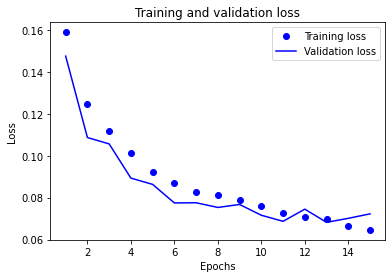

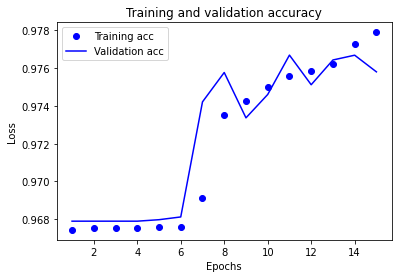

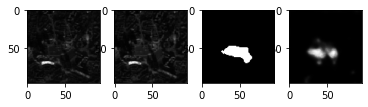

Dice similarity score is 0.49956581656898463


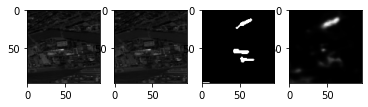

Dice similarity score is 0.23891502593771397


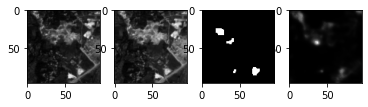

Dice similarity score is 0.13920545413977511


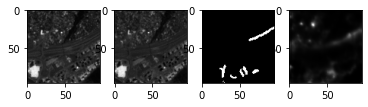

Dice similarity score is 0.03194433796296155


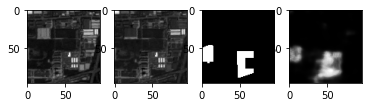

Dice similarity score is 0.5792872688323178


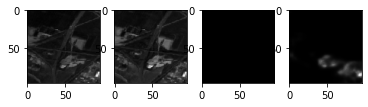

Dice similarity score is 0.0


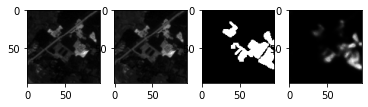

Dice similarity score is 0.329738781808619


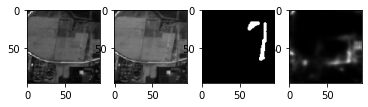

Dice similarity score is 0.031788755112074046


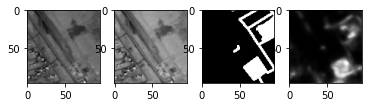

Dice similarity score is 0.42861117633874235


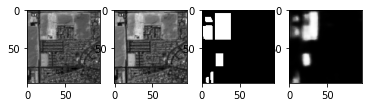

Dice similarity score is 0.7069948869164789


In [ ]:
model = unet()
model.save_weights('model4.h5')
history = model.fit(X_train, y_train, batch_size=2, epochs=15, verbose=1,validation_split=0.2, shuffle=True)
results = model.predict(X_test)

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)

print(model.summary)


plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


from scipy.spatial import distance

sumdice = 0
for i in range(10):

  img = results[i]
  img1 = y_test[i]
  img2 = X_test[i]
  fig, (ax1, ax2, ax3, ax4) =  plt.subplots(1,4)
  ax1.imshow(img2[:,:,0], cmap = 'gray')
  ax2.imshow(img2[:,:,1], cmap = 'gray')
  ax4.imshow(img[:,:,0], cmap = 'gray')
  ax3.imshow(img1[:,:,0], cmap = 'gray')
  plt.show()
  dice = np.sum(img[:,:,0][img1[:,:,0]==1])*2.0 / (np.sum(img[:,:,0]) + np.sum(img1[:,:,0]))
  print("Dice similarity score is {}".format(dice))

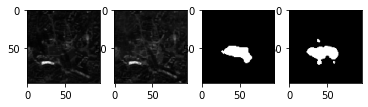

Dice similarity score is 0.7623318385650224


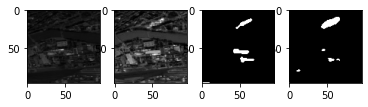

Dice similarity score is 0.5284403669724771


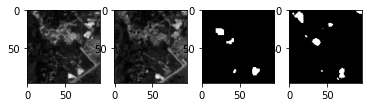

Dice similarity score is 0.32246998284734135


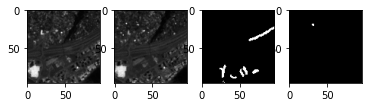

Dice similarity score is 0.0


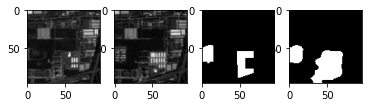

Dice similarity score is 0.6785290628706999


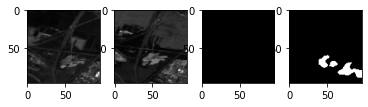

Dice similarity score is 0.0


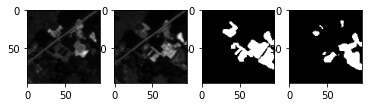

Dice similarity score is 0.683375104427736


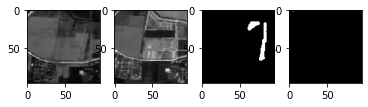

Dice similarity score is 0.0


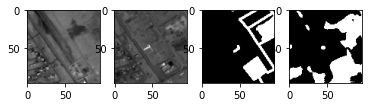

Dice similarity score is 0.615916955017301


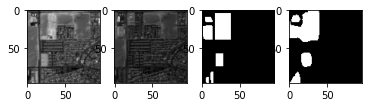

Dice similarity score is 0.843546730571722


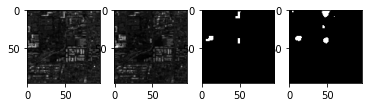

Dice similarity score is 0.54421768707483


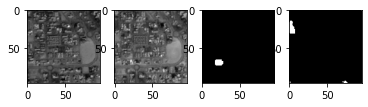

Dice similarity score is 0.0


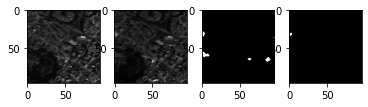

Dice similarity score is 0.21238938053097345


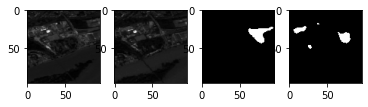

Dice similarity score is 0.47058823529411764


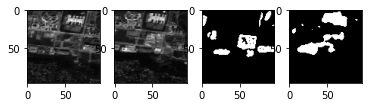

Dice similarity score is 0.27548209366391185


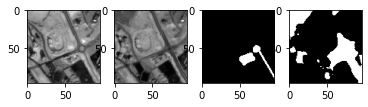

Dice similarity score is 0.28208005985783763


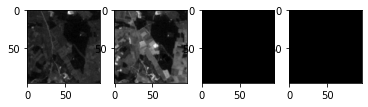

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


Dice similarity score is nan


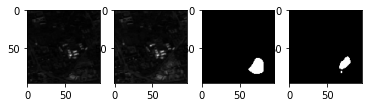

Dice similarity score is 0.6217391304347826


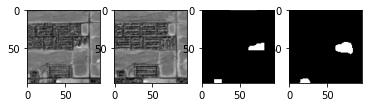

Dice similarity score is 0.717948717948718


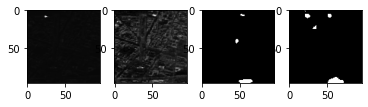

Dice similarity score is 0.535593220338983


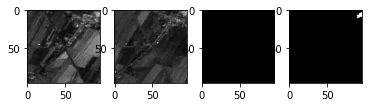

Dice similarity score is 0.0


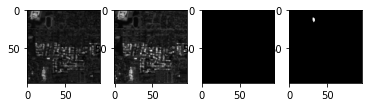

Dice similarity score is 0.0


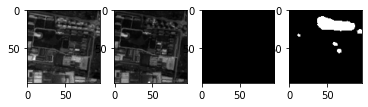

Dice similarity score is 0.0


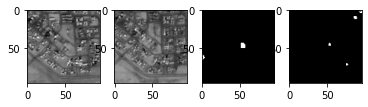

Dice similarity score is 0.19607843137254902


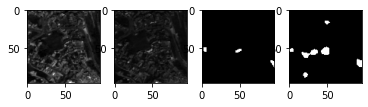

Dice similarity score is 0.35990888382687924


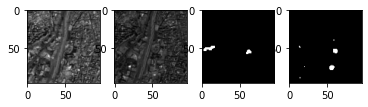

Dice similarity score is 0.31137724550898205


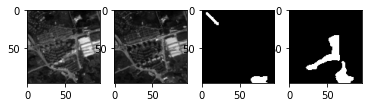

Dice similarity score is 0.26215993404781535


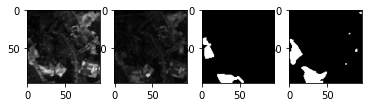

Dice similarity score is 0.6757164404223228


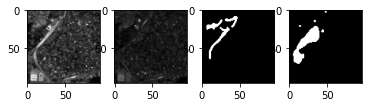

Dice similarity score is 0.36688617121354655


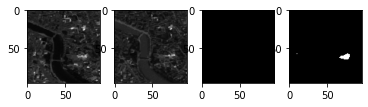

Dice similarity score is 0.0


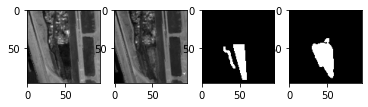

Dice similarity score is 0.7545691906005222


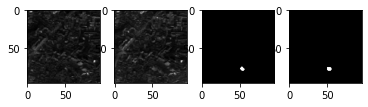

Dice similarity score is 0.88


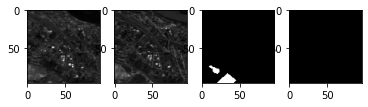

Dice similarity score is 0.0


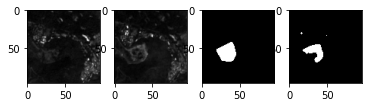

Dice similarity score is 0.7851851851851852


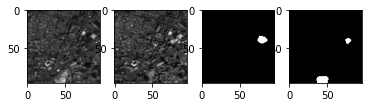

Dice similarity score is 0.29850746268656714


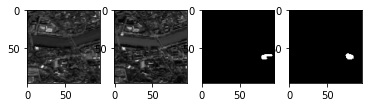

Dice similarity score is 0.5648854961832062


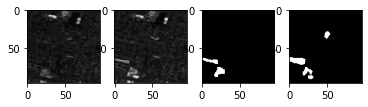

Dice similarity score is 0.6303501945525292


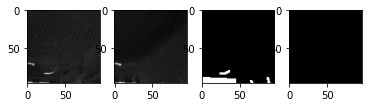

Dice similarity score is 0.0


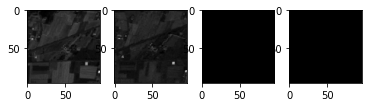

Dice similarity score is nan


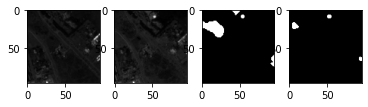

Dice similarity score is 0.3074484944532488


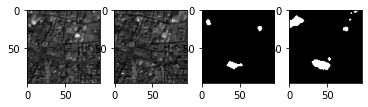

Dice similarity score is 0.5348837209302325


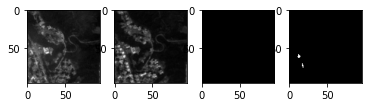

Dice similarity score is 0.0


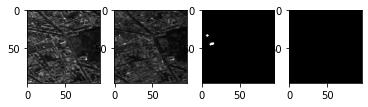

Dice similarity score is 0.0


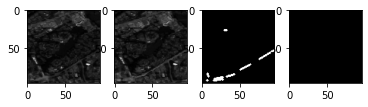

Dice similarity score is 0.0


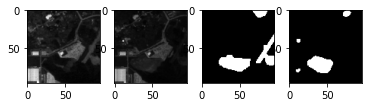

Dice similarity score is 0.6038961038961039


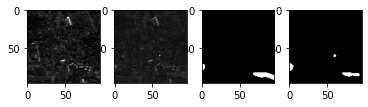

Dice similarity score is 0.6798866855524079


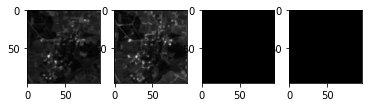

Dice similarity score is nan


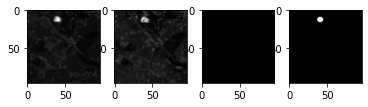

Dice similarity score is 0.0


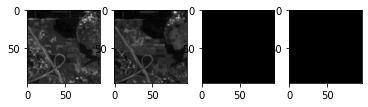

Dice similarity score is nan


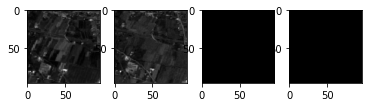

Dice similarity score is nan


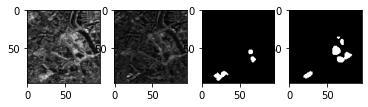

Dice similarity score is 0.4981684981684982


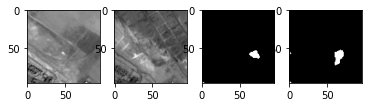

Dice similarity score is 0.5217391304347826


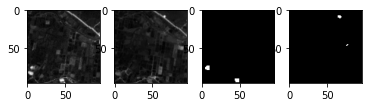

Dice similarity score is 0.0


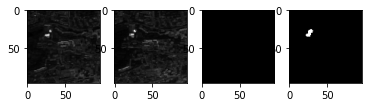

Dice similarity score is 0.0


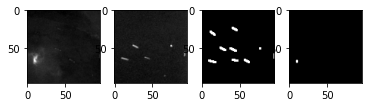

Dice similarity score is 0.06896551724137931


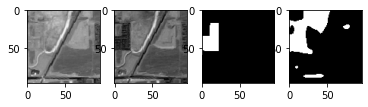

Dice similarity score is 0.5083532219570406


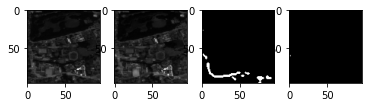

Dice similarity score is 0.006349206349206349


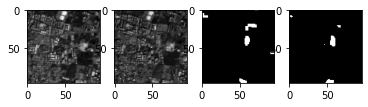

Dice similarity score is 0.5620253164556962


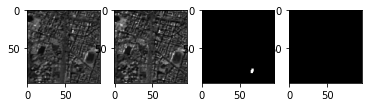

Dice similarity score is 0.0


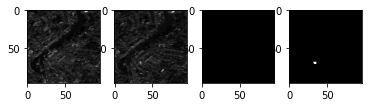

Dice similarity score is 0.0


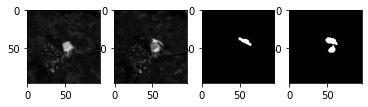

Dice similarity score is 0.5793650793650794


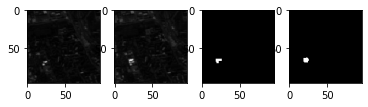

Dice similarity score is 0.7123287671232876


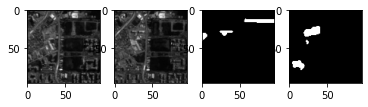

Dice similarity score is 0.20864381520119224


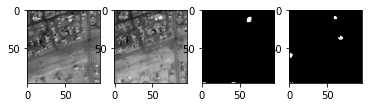

Dice similarity score is 0.21238938053097345


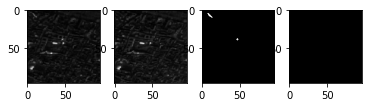

Dice similarity score is 0.0


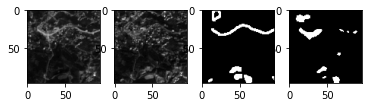

Dice similarity score is 0.5534204458109147


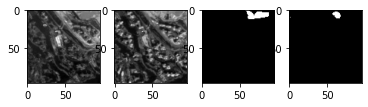

Dice similarity score is 0.4013377926421405


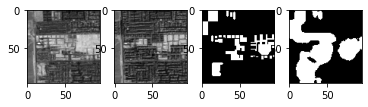

Dice similarity score is 0.5919145690312738


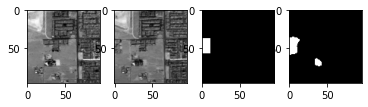

Dice similarity score is 0.7927272727272727


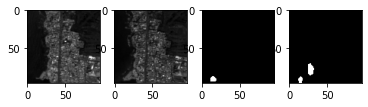

Dice similarity score is 0.34065934065934067


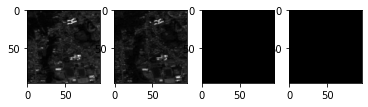

Dice similarity score is nan


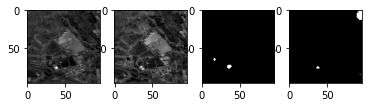

Dice similarity score is 0.09836065573770492


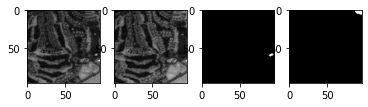

Dice similarity score is 0.0


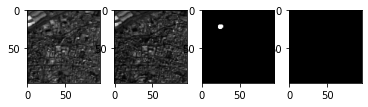

Dice similarity score is 0.0


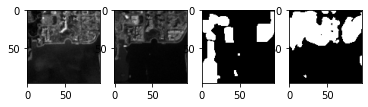

Dice similarity score is 0.5344430671152824


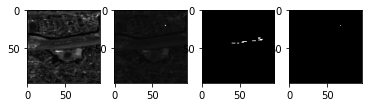

Dice similarity score is 0.0


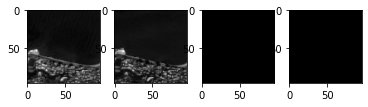

Dice similarity score is nan


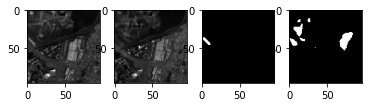

Dice similarity score is 0.15445544554455445


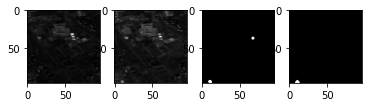

Dice similarity score is 0.6382978723404256


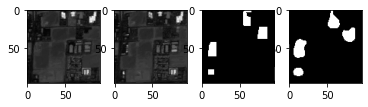

Dice similarity score is 0.7129217059197963


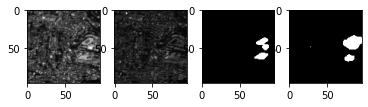

Dice similarity score is 0.6


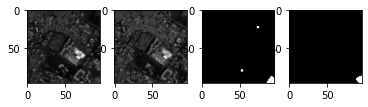

Dice similarity score is 0.6802721088435374


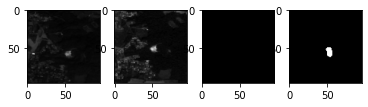

Dice similarity score is 0.0


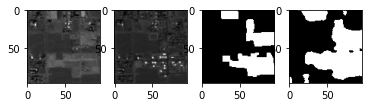

Dice similarity score is 0.7634079561926236


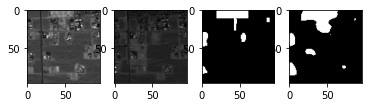

Dice similarity score is 0.6669931439764937


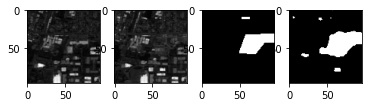

Dice similarity score is 0.7755474452554745


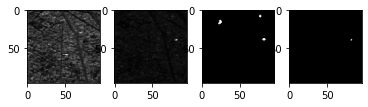

Dice similarity score is 0.15


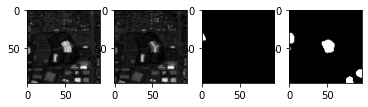

Dice similarity score is 0.15476190476190477


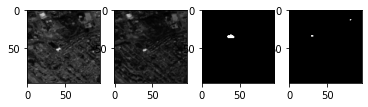

Dice similarity score is 0.0


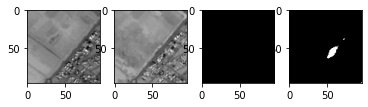

Dice similarity score is 0.0


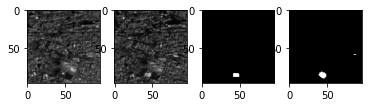

Dice similarity score is 0.7428571428571429
Dice similarity score is 0.5483463844190115


In [ ]:
tempArray = np.copy(results)
for element in np.nditer(tempArray, op_flags=['readwrite']):
  if element > .1:
    element[...] = 1
  else:
    element[...] = 0
y = []
numer = 0
denom = 0
for i in range(91):
  img = tempArray[i]
  img1 = y_test[i]
  img2 = X_test[i]
  fig, (ax1, ax2, ax3, ax4) =  plt.subplots(1,4)
  ax1.imshow(img2[:,:,0], cmap = 'gray')
  ax2.imshow(img2[:,:,4], cmap = 'gray')
  ax4.imshow(img[:,:,0], cmap = 'gray')
  ax3.imshow(img1[:,:,0], cmap = 'gray')
  plt.show()
  dice = np.sum(img[:,:,0][img1[:,:,0]==1])*2.0 / (np.sum(img[:,:,0]) + np.sum(img1[:,:,0]))
  numer += np.sum(img[:,:,0][img1[:,:,0]==1])
  denom += (np.sum(img[:,:,0]) + np.sum(img1[:,:,0]))
  dice1 = np.sum(img[:,:,0][img1[:,:,0]==1])*2.0 / (np.sum(img[:,:,0]) + np.sum(img1[:,:,0]))
  print("Dice similarity score is {}".format(dice1))
  dice = numer * 2/ denom

print("Dice similarity score is {}".format(dice))